# IIE4123 HW3
## Kichang Lee(2019193016), School of Integrated Technology, Yonsei Univ

Language : Python3(Python 3.9.7 64-bit)

OS : Microsoft Windows 10 Education (10.0.19042)

Environment

CPU : Intel(R) Core(TM) i9-10850K CPU 3.60GHz, 3600Mhz, 10 Core with Intel(R) UHD Graphics 630

RAM : 64GB

GPU : RTX3090

## Notes about Task1


Task1 : (Data Augmentation and Dropout) Open the Image Classification ipynb. The file contains the details of workflow and descriptions. Please check each line of code and learn a basic machine learning workflow.

(a) Demonstrate the performance difference with/without data augmentation. Please try to make performance improvements using the proper data augmentations. You may need to show training and validation loss.
Note: you can also refer to transfer learning code for other data augmentation types.

-> The result with data augmentation showed better performance in both inspect of validation accuracy and validation loss. You can check that out in the following code outputs. To note that I applied 3 augmentation(rotation, horizontal and vertical flip for 20%) differently from the basic one.

(b) Demonstrate the performance difference with/without dropout (you can specify percentage). Please try to make performance improvements using the proper dropout usage. You may need to show training and validation loss.

-> I trained 4 models with dropout. Each models' dropout rates were set in 0.2, 0.4, 0.6 and 0.8. Models with dropout showed better performance compared to the basic one in inspect of the validation loss. In addition, the one with the dropout rate 0.2 showed the most robust fit in my opinion.

(c) Do some experiments to improve validation loss with the combinations of dropout and data augmentation. The goal is to improve validation accuracy.

-> I combined the dropout and data augmetation. The best model in inspect of accuracy was the one with dropout rate 0.6 and applying the data augmentation methods. It showed 82.61 % validation accuracy and validation loss in 1.76703. The best model in validation loss was the one with dropout rate 0.8 and aaplying the data augmentation techniques. It showed 76.09 % accuracy and 1.17587 of validation loss.

By the way, I think the given model in the handed out code is not enough deep or big to fully understand or learn the dataset. All the models I've tried seemed to be overfitted. I think it would be nice to test through other, deeper and complex model for this task.


## Download and explore the dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

# import Packages

In [2]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# Data Management

In [3]:
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
EPOCHS = 100


USE_CUDA = torch.cuda.is_available() 
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 
print("다음 기기로 학습합니다:", DEVICE)

img_height = 180

다음 기기로 학습합니다: cuda


In [4]:
transforms_ = transforms.Compose([
                               transforms.Scale(img_height),       
                               transforms.CenterCrop(img_height),  
                               transforms.ToTensor(),       
                           ])

augment_transforms_ = transforms.Compose([
                               transforms.Scale(img_height),       
                               transforms.CenterCrop(img_height),  
                               transforms.RandomHorizontalFlip(p=0.2),
                               transforms.RandomVerticalFlip(p=0.2),
                               transforms.RandomRotation(45),
                               transforms.ToTensor(),
                           ])

C:\Users\Kichang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\transforms\transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
dataset = dset.ImageFolder(root=data_dir,
                           transform = transforms_
                           )

TRAIN_SET, VAL_SET = train_test_split(dataset, test_size = 0.2, stratify=dataset.targets)

train_loader = torch.utils.data.DataLoader(TRAIN_SET, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(VAL_SET, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [6]:
dataset = dset.ImageFolder(root=data_dir,
                           transform = augment_transforms_
                           )

AUG_TRAIN_SET, AUG_VAL_SET = train_test_split(dataset, test_size = 0.2, stratify=dataset.targets)

aug_train_loader = torch.utils.data.DataLoader(AUG_TRAIN_SET, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

aug_val_loader = torch.utils.data.DataLoader(AUG_VAL_SET, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Model

In [7]:
class Conv_Net(nn.Module):
    def __init__(self, dropout_rate = 0):
        super(Conv_Net, self).__init__()
        in_channels = [3, 16, 32]
        out_channels = [16, 32, 64]
        self.network = nn.Sequential(
            #(180, 180, 3)
            nn.Conv2d(in_channels[0], out_channels[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #(90, 90, 16)
            nn.Conv2d(in_channels[1], out_channels[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #(45, 45, 32)
            nn.Conv2d(in_channels[2], out_channels[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=dropout_rate),
            
            #(22, 22, 64)
            nn.Flatten(),
            nn.Linear(22*22*64, 128),
            nn.ReLU(),
            nn.Linear(128, 5))

    def forward(self, x):
        return self.network(x)


In [8]:
dropout_rates = [0.2, 0.4, 0.6, 0.8]


model_name = ['basic CNN',
              f'with dropout={dropout_rates[0]}',
              f'with dropout={dropout_rates[1]}',
              f'with dropout={dropout_rates[2]}',
              f'with dropout={dropout_rates[3]}',]


models = [Conv_Net().to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[0]).to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[1]).to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[2]).to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[3]).to(DEVICE)]

criterion = nn.CrossEntropyLoss().to(DEVICE)

In [9]:
LOSSES_TRAIN, LOSSES_VAL = [[] for idx in range(len(models))], [[] for idx in range(len(models))]
ACCS_VAL = [[] for idx in range(len(models))]

for model_idx, model in enumerate(models):
    start = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in tqdm(range(EPOCHS), desc="EPOCHS"):
        model.train()
        LOSS_TRACE_FOR_TRAIN, LOSS_TRACE_FOR_VAL = [], []
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            X_train, Y_train = batch
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)

            Y_pred_train = model(X_train)
            Y_train = Y_train.squeeze(-1)

            LOSS_train = criterion(Y_pred_train, Y_train)

            LOSS_TRACE_FOR_TRAIN.append(LOSS_train.cpu().detach().numpy())
            LOSS_train.backward()
            optimizer.step()        

        with torch.no_grad():
            model.eval()

            Result_pred_val, Result_anno_val = [], []
            for idx, batch in enumerate(val_loader):
                X_val, Y_val = batch
                X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)

                Y_pred_val = model(X_val)
                Y_val = Y_val.squeeze(-1)
                LOSS_val = criterion(Y_pred_val, Y_val)

                LOSS_TRACE_FOR_VAL.append(LOSS_val.cpu().detach().numpy())

                Y_pred_val_np  = Y_pred_val.to('cpu').detach().numpy()
                Y_pred_val_np  = np.argmax(Y_pred_val_np, axis=1).reshape(-1, 1)
                Y_val_np       = Y_val.to('cpu').detach().numpy().reshape(-1, 1)

                Result_pred_val.append(list(Y_pred_val_np[0]))
                Result_anno_val.append(list(Y_val_np[0]))
            

            ACC_VAL        = metrics.accuracy_score(Result_anno_val, Result_pred_val)

            AVG_LOSS_TRAIN = np.average(LOSS_TRACE_FOR_TRAIN)
            AVG_LOSS_VAL   = np.average(LOSS_TRACE_FOR_VAL)

            LOSSES_TRAIN[model_idx].append(AVG_LOSS_TRAIN)
            LOSSES_VAL[model_idx].append(AVG_LOSS_VAL)
            ACCS_VAL[model_idx].append(ACC_VAL)

            print(f'(epoch {epoch + 1:03d}/{EPOCHS}) Training Loss : {AVG_LOSS_TRAIN:.5f} | Validation Loss : {AVG_LOSS_VAL:.5f} | Validation Accuracy : {ACC_VAL*100:.2f} %')
        
    end = time.time()
    print(f"{model_name[model_idx]} Training took {end-start:.2f} sec")

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Kichang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(epoch 001/100) Training Loss : 1.42910 | Validation Loss : 1.20058 | Validation Accuracy : 47.83 %
(epoch 002/100) Training Loss : 1.15954 | Validation Loss : 1.10364 | Validation Accuracy : 60.87 %
(epoch 003/100) Training Loss : 1.08044 | Validation Loss : 1.08819 | Validation Accuracy : 60.87 %
(epoch 004/100) Training Loss : 1.01611 | Validation Loss : 1.05577 | Validation Accuracy : 65.22 %
(epoch 005/100) Training Loss : 0.97446 | Validation Loss : 1.02496 | Validation Accuracy : 63.04 %
(epoch 006/100) Training Loss : 0.93448 | Validation Loss : 0.98525 | Validation Accuracy : 60.87 %
(epoch 007/100) Training Loss : 0.88834 | Validation Loss : 0.97767 | Validation Accuracy : 60.87 %
(epoch 008/100) Training Loss : 0.84662 | Validation Loss : 0.94730 | Validation Accuracy : 67.39 %
(epoch 009/100) Training Loss : 0.80378 | Validation Loss : 0.94755 | Validation Accuracy : 60.87 %
(epoch 010/100) Training Loss : 0.76667 | Validation Loss : 0.96558 | Validation Accuracy : 63.04 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.42972 | Validation Loss : 1.23234 | Validation Accuracy : 47.83 %
(epoch 002/100) Training Loss : 1.14343 | Validation Loss : 1.08937 | Validation Accuracy : 56.52 %
(epoch 003/100) Training Loss : 1.05838 | Validation Loss : 1.08457 | Validation Accuracy : 54.35 %
(epoch 004/100) Training Loss : 1.00065 | Validation Loss : 1.02894 | Validation Accuracy : 58.70 %
(epoch 005/100) Training Loss : 0.95417 | Validation Loss : 1.03481 | Validation Accuracy : 63.04 %
(epoch 006/100) Training Loss : 0.90986 | Validation Loss : 0.96871 | Validation Accuracy : 60.87 %
(epoch 007/100) Training Loss : 0.87216 | Validation Loss : 0.96605 | Validation Accuracy : 56.52 %
(epoch 008/100) Training Loss : 0.84510 | Validation Loss : 0.96342 | Validation Accuracy : 63.04 %
(epoch 009/100) Training Loss : 0.80033 | Validation Loss : 0.92448 | Validation Accuracy : 60.87 %
(epoch 010/100) Training Loss : 0.77408 | Validation Loss : 0.91968 | Validation Accuracy : 63.04 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.37730 | Validation Loss : 1.19514 | Validation Accuracy : 56.52 %
(epoch 002/100) Training Loss : 1.12800 | Validation Loss : 1.07106 | Validation Accuracy : 58.70 %
(epoch 003/100) Training Loss : 1.06162 | Validation Loss : 1.04288 | Validation Accuracy : 58.70 %
(epoch 004/100) Training Loss : 1.00494 | Validation Loss : 1.02074 | Validation Accuracy : 63.04 %
(epoch 005/100) Training Loss : 0.95993 | Validation Loss : 1.01280 | Validation Accuracy : 60.87 %
(epoch 006/100) Training Loss : 0.91724 | Validation Loss : 0.97526 | Validation Accuracy : 60.87 %
(epoch 007/100) Training Loss : 0.88081 | Validation Loss : 0.99375 | Validation Accuracy : 56.52 %
(epoch 008/100) Training Loss : 0.84577 | Validation Loss : 0.93868 | Validation Accuracy : 65.22 %
(epoch 009/100) Training Loss : 0.81989 | Validation Loss : 0.98271 | Validation Accuracy : 60.87 %
(epoch 010/100) Training Loss : 0.78616 | Validation Loss : 0.93259 | Validation Accuracy : 63.04 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.37473 | Validation Loss : 1.18957 | Validation Accuracy : 52.17 %
(epoch 002/100) Training Loss : 1.13523 | Validation Loss : 1.11183 | Validation Accuracy : 52.17 %
(epoch 003/100) Training Loss : 1.06429 | Validation Loss : 1.06729 | Validation Accuracy : 56.52 %
(epoch 004/100) Training Loss : 1.00434 | Validation Loss : 1.01481 | Validation Accuracy : 58.70 %
(epoch 005/100) Training Loss : 0.95760 | Validation Loss : 0.99718 | Validation Accuracy : 56.52 %
(epoch 006/100) Training Loss : 0.92994 | Validation Loss : 0.99360 | Validation Accuracy : 58.70 %
(epoch 007/100) Training Loss : 0.89302 | Validation Loss : 0.96156 | Validation Accuracy : 60.87 %
(epoch 008/100) Training Loss : 0.85267 | Validation Loss : 0.94821 | Validation Accuracy : 65.22 %
(epoch 009/100) Training Loss : 0.82603 | Validation Loss : 0.98801 | Validation Accuracy : 67.39 %
(epoch 010/100) Training Loss : 0.79385 | Validation Loss : 0.94531 | Validation Accuracy : 58.70 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.44903 | Validation Loss : 1.26510 | Validation Accuracy : 47.83 %
(epoch 002/100) Training Loss : 1.20429 | Validation Loss : 1.12942 | Validation Accuracy : 60.87 %
(epoch 003/100) Training Loss : 1.10597 | Validation Loss : 1.06197 | Validation Accuracy : 63.04 %
(epoch 004/100) Training Loss : 1.04403 | Validation Loss : 1.06595 | Validation Accuracy : 60.87 %
(epoch 005/100) Training Loss : 0.98937 | Validation Loss : 0.99581 | Validation Accuracy : 58.70 %
(epoch 006/100) Training Loss : 0.96113 | Validation Loss : 1.00159 | Validation Accuracy : 58.70 %
(epoch 007/100) Training Loss : 0.91493 | Validation Loss : 0.95827 | Validation Accuracy : 60.87 %
(epoch 008/100) Training Loss : 0.88411 | Validation Loss : 0.94704 | Validation Accuracy : 63.04 %
(epoch 009/100) Training Loss : 0.85380 | Validation Loss : 0.95018 | Validation Accuracy : 58.70 %
(epoch 010/100) Training Loss : 0.82354 | Validation Loss : 0.94679 | Validation Accuracy : 63.04 %


In [10]:
aug_models = [Conv_Net().to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[0]).to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[1]).to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[2]).to(DEVICE),
          Conv_Net(dropout_rate = dropout_rates[3]).to(DEVICE)]

model_name = ['basic CNN',
              f'with dropout={dropout_rates[0]}',
              f'with dropout={dropout_rates[1]}',
              f'with dropout={dropout_rates[2]}',
              f'with dropout={dropout_rates[3]}',]

for i in range(len(model_name)):
    model_name.append(model_name[i]+' with augmentation')

criterion = nn.CrossEntropyLoss().to(DEVICE)

In [11]:
AUG_LOSSES_TRAIN, AUG_LOSSES_VAL = [[] for idx in range(len(aug_models))], [[] for idx in range(len(aug_models))]
AUG_ACCS_VAL = [[] for idx in range(len(aug_models))]

for model_idx, model in enumerate(aug_models):
    start = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in tqdm(range(EPOCHS), desc="EPOCHS"):
        model.train()
        LOSS_TRACE_FOR_TRAIN, LOSS_TRACE_FOR_VAL = [], []
        for idx, batch in enumerate(aug_train_loader):
            optimizer.zero_grad()

            X_train, Y_train = batch
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)

            Y_pred_train = model(X_train)
            Y_train = Y_train.squeeze(-1)

            LOSS_train = criterion(Y_pred_train, Y_train)

            LOSS_TRACE_FOR_TRAIN.append(LOSS_train.cpu().detach().numpy())
            LOSS_train.backward()
            optimizer.step()        

        with torch.no_grad():
            model.eval()

            Result_pred_val, Result_anno_val = [], []
            for idx, batch in enumerate(val_loader):
                X_val, Y_val = batch
                X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)

                Y_pred_val = model(X_val)
                Y_val = Y_val.squeeze(-1)
                LOSS_val = criterion(Y_pred_val, Y_val)

                LOSS_TRACE_FOR_VAL.append(LOSS_val.cpu().detach().numpy())

                Y_pred_val_np  = Y_pred_val.to('cpu').detach().numpy()
                Y_pred_val_np  = np.argmax(Y_pred_val_np, axis=1).reshape(-1, 1)
                Y_val_np       = Y_val.to('cpu').detach().numpy().reshape(-1, 1)

                Result_pred_val.append(list(Y_pred_val_np[0]))
                Result_anno_val.append(list(Y_val_np[0]))
            

            ACC_VAL        = metrics.accuracy_score(Result_anno_val, Result_pred_val)

            AVG_LOSS_TRAIN = np.average(LOSS_TRACE_FOR_TRAIN)
            AVG_LOSS_VAL   = np.average(LOSS_TRACE_FOR_VAL)

            AUG_LOSSES_TRAIN[model_idx].append(AVG_LOSS_TRAIN)
            AUG_LOSSES_VAL[model_idx].append(AVG_LOSS_VAL)
            AUG_ACCS_VAL[model_idx].append(ACC_VAL)

            print(f'(epoch {epoch + 1:03d}/{EPOCHS}) Training Loss : {AVG_LOSS_TRAIN:.5f} | Validation Loss : {AVG_LOSS_VAL:.5f} | Validation Accuracy : {ACC_VAL*100:.2f} %')
        
    end = time.time()
    print(f"{model_name[model_idx+5]} Training took {end-start:.2f} sec")

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.41122 | Validation Loss : 1.21340 | Validation Accuracy : 45.65 %
(epoch 002/100) Training Loss : 1.15543 | Validation Loss : 1.08711 | Validation Accuracy : 54.35 %
(epoch 003/100) Training Loss : 1.09295 | Validation Loss : 1.03704 | Validation Accuracy : 56.52 %
(epoch 004/100) Training Loss : 1.03543 | Validation Loss : 1.02136 | Validation Accuracy : 63.04 %
(epoch 005/100) Training Loss : 1.00103 | Validation Loss : 0.97322 | Validation Accuracy : 65.22 %
(epoch 006/100) Training Loss : 0.96457 | Validation Loss : 0.97212 | Validation Accuracy : 65.22 %
(epoch 007/100) Training Loss : 0.92589 | Validation Loss : 0.94544 | Validation Accuracy : 71.74 %
(epoch 008/100) Training Loss : 0.89662 | Validation Loss : 0.91496 | Validation Accuracy : 63.04 %
(epoch 009/100) Training Loss : 0.87004 | Validation Loss : 0.98471 | Validation Accuracy : 71.74 %
(epoch 010/100) Training Loss : 0.83285 | Validation Loss : 0.89758 | Validation Accuracy : 73.91 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.51877 | Validation Loss : 1.38718 | Validation Accuracy : 45.65 %
(epoch 002/100) Training Loss : 1.30029 | Validation Loss : 1.21365 | Validation Accuracy : 45.65 %
(epoch 003/100) Training Loss : 1.15054 | Validation Loss : 1.07733 | Validation Accuracy : 56.52 %
(epoch 004/100) Training Loss : 1.08353 | Validation Loss : 1.04026 | Validation Accuracy : 63.04 %
(epoch 005/100) Training Loss : 1.03180 | Validation Loss : 0.99745 | Validation Accuracy : 58.70 %
(epoch 006/100) Training Loss : 0.99382 | Validation Loss : 0.99175 | Validation Accuracy : 60.87 %
(epoch 007/100) Training Loss : 0.96902 | Validation Loss : 0.95034 | Validation Accuracy : 60.87 %
(epoch 008/100) Training Loss : 0.93204 | Validation Loss : 0.93209 | Validation Accuracy : 63.04 %
(epoch 009/100) Training Loss : 0.90511 | Validation Loss : 0.92121 | Validation Accuracy : 65.22 %
(epoch 010/100) Training Loss : 0.88446 | Validation Loss : 0.89744 | Validation Accuracy : 67.39 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.51479 | Validation Loss : 1.31630 | Validation Accuracy : 39.13 %
(epoch 002/100) Training Loss : 1.24215 | Validation Loss : 1.13280 | Validation Accuracy : 60.87 %
(epoch 003/100) Training Loss : 1.11781 | Validation Loss : 1.10595 | Validation Accuracy : 52.17 %
(epoch 004/100) Training Loss : 1.07735 | Validation Loss : 1.05099 | Validation Accuracy : 58.70 %
(epoch 005/100) Training Loss : 1.02922 | Validation Loss : 1.02327 | Validation Accuracy : 56.52 %
(epoch 006/100) Training Loss : 1.00131 | Validation Loss : 0.99374 | Validation Accuracy : 63.04 %
(epoch 007/100) Training Loss : 0.97495 | Validation Loss : 0.98228 | Validation Accuracy : 56.52 %
(epoch 008/100) Training Loss : 0.94172 | Validation Loss : 1.01204 | Validation Accuracy : 63.04 %
(epoch 009/100) Training Loss : 0.91387 | Validation Loss : 0.98901 | Validation Accuracy : 58.70 %
(epoch 010/100) Training Loss : 0.89716 | Validation Loss : 0.93663 | Validation Accuracy : 63.04 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.40599 | Validation Loss : 1.18020 | Validation Accuracy : 54.35 %
(epoch 002/100) Training Loss : 1.15685 | Validation Loss : 1.08694 | Validation Accuracy : 52.17 %
(epoch 003/100) Training Loss : 1.09020 | Validation Loss : 1.03961 | Validation Accuracy : 60.87 %
(epoch 004/100) Training Loss : 1.03371 | Validation Loss : 1.00123 | Validation Accuracy : 65.22 %
(epoch 005/100) Training Loss : 0.99381 | Validation Loss : 0.98241 | Validation Accuracy : 58.70 %
(epoch 006/100) Training Loss : 0.96095 | Validation Loss : 0.97546 | Validation Accuracy : 60.87 %
(epoch 007/100) Training Loss : 0.92150 | Validation Loss : 0.94728 | Validation Accuracy : 67.39 %
(epoch 008/100) Training Loss : 0.89056 | Validation Loss : 0.91988 | Validation Accuracy : 69.57 %
(epoch 009/100) Training Loss : 0.86508 | Validation Loss : 0.89927 | Validation Accuracy : 69.57 %
(epoch 010/100) Training Loss : 0.83999 | Validation Loss : 0.88860 | Validation Accuracy : 69.57 %


EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

(epoch 001/100) Training Loss : 1.52678 | Validation Loss : 1.39219 | Validation Accuracy : 43.48 %
(epoch 002/100) Training Loss : 1.28723 | Validation Loss : 1.17892 | Validation Accuracy : 50.00 %
(epoch 003/100) Training Loss : 1.15995 | Validation Loss : 1.09054 | Validation Accuracy : 54.35 %
(epoch 004/100) Training Loss : 1.10208 | Validation Loss : 1.04462 | Validation Accuracy : 63.04 %
(epoch 005/100) Training Loss : 1.05037 | Validation Loss : 1.01806 | Validation Accuracy : 65.22 %
(epoch 006/100) Training Loss : 1.01724 | Validation Loss : 0.98336 | Validation Accuracy : 63.04 %
(epoch 007/100) Training Loss : 0.97535 | Validation Loss : 0.96700 | Validation Accuracy : 60.87 %
(epoch 008/100) Training Loss : 0.95552 | Validation Loss : 0.93826 | Validation Accuracy : 67.39 %
(epoch 009/100) Training Loss : 0.94163 | Validation Loss : 0.95611 | Validation Accuracy : 63.04 %
(epoch 010/100) Training Loss : 0.90532 | Validation Loss : 0.97061 | Validation Accuracy : 65.22 %


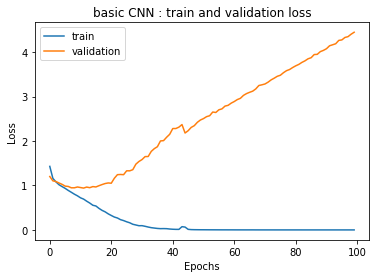

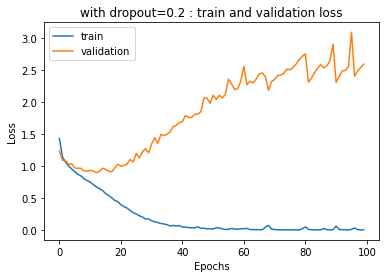

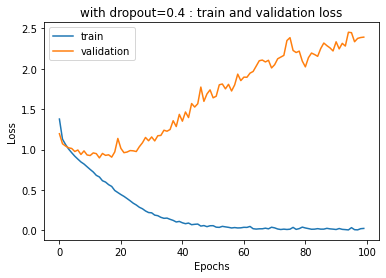

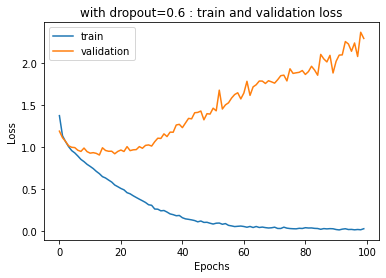

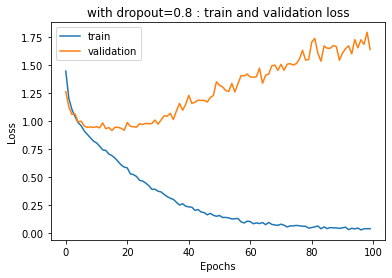

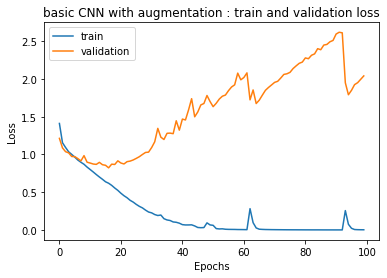

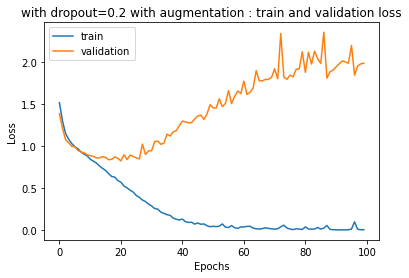

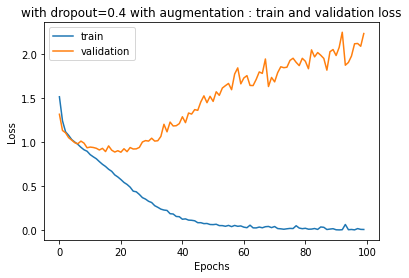

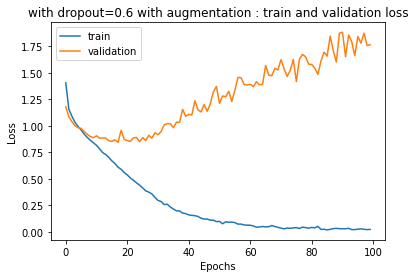

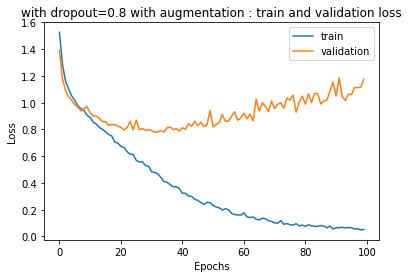

In [12]:
for model_idx, loss in enumerate(LOSSES_TRAIN):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name[model_idx]} : train and validation loss')
    plt.plot(LOSSES_TRAIN[model_idx], label = 'train')
    plt.plot(LOSSES_VAL[model_idx], label = 'validation')
    plt.legend()
    plt.show()

for model_idx, loss in enumerate(AUG_LOSSES_TRAIN):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name[model_idx+5]} : train and validation loss')
    plt.plot(AUG_LOSSES_TRAIN[model_idx], label = 'train')
    plt.plot(AUG_LOSSES_VAL[model_idx], label = 'validation')
    plt.legend()
    plt.show()

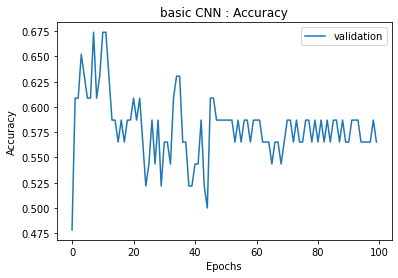

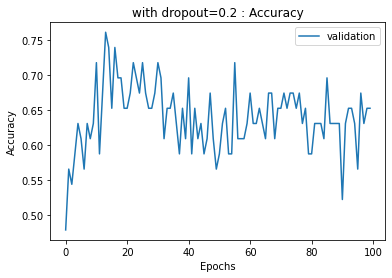

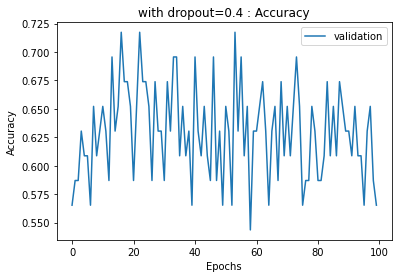

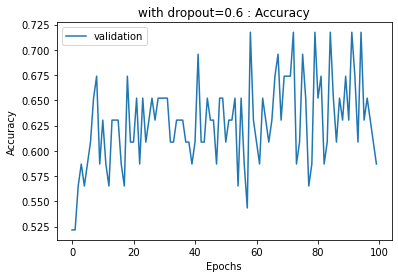

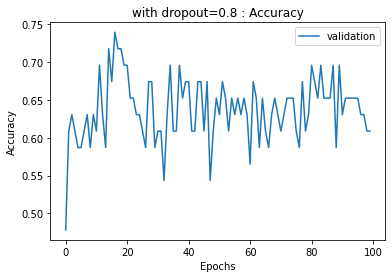

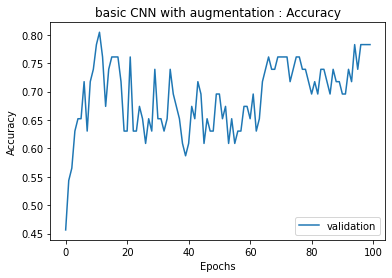

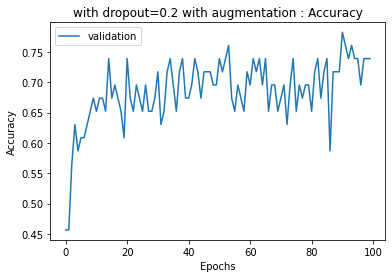

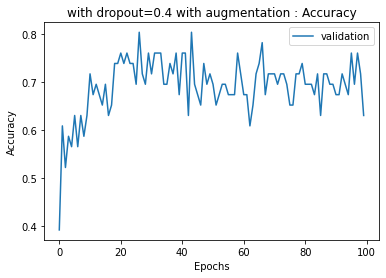

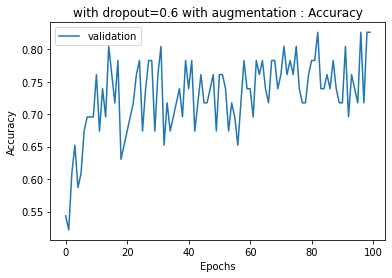

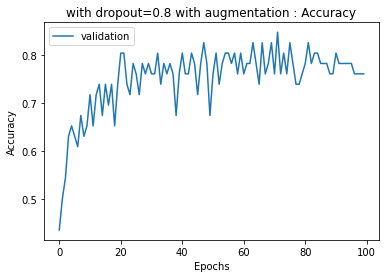

In [13]:
for model_idx, acc in enumerate(LOSSES_TRAIN):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name[model_idx]} : Accuracy')
    plt.plot(ACCS_VAL[model_idx], label = 'validation')
    plt.legend()
    plt.show()

for model_idx, acc in enumerate(AUG_LOSSES_TRAIN):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name[model_idx+5]} : Accuracy')
    plt.plot(AUG_ACCS_VAL[model_idx], label = 'validation')
    plt.legend()
    plt.show()